# Basic SA with FARM

Based on: https://colab.research.google.com/drive/130_7dgVC3VdLBPhiEkGULHmqSlflhmVM  
...with a few modifications to make it work for basic sentiment (valence) classification

### Setup

In [1]:
# Install FARM
!pip install torch==1.8.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install farm==0.7.1

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 204kB 13.6MB/s 
     |████████████████████████████████| 1.5MB 34.4MB/s 
     |████████████████████████████████| 2.5MB 52.0MB/s 
     |████████████████████████████████| 14.2MB 48.6MB/s 
     |████████████████████████████████| 327kB 50.0MB/s 
     |████████████████████████████████| 1.2MB 39.2MB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 133kB 57.1MB/s 
     |████████████████████████████████| 51kB 9.5MB/s 
     |████████████████████████████████| 901kB 40.2MB/s 
     |████████████████████████████████| 2.9MB 32.5MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 174kB 56.4MB/s 
     |████████████████████████████████| 81kB 13.9MB/s 
     |████████████████████████████████| 153kB 60.5MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 1

In [2]:
# Here are the imports we need

import torch
from farm.modeling.tokenization import Tokenizer
from farm.data_handler.processor import TextClassificationProcessor
from farm.data_handler.data_silo import DataSilo
from farm.modeling.language_model import LanguageModel
from farm.modeling.prediction_head import TextClassificationHead
from farm.modeling.adaptive_model import AdaptiveModel
from farm.modeling.optimization import initialize_optimizer
from farm.train import Trainer
from farm.utils import MLFlowLogger


06/10/2021 16:06:29 - INFO - farm.modeling.prediction_head -   Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


In [ ]:
# Farm allows simple logging of many parameters & metrics. Let's use the MLflow framework to track our experiment ...
# You will see your results on https://public-mlflow.deepset.ai/
ml_logger = MLFlowLogger(tracking_uri="https://public-mlflow.deepset.ai/")
ml_logger.init_experiment(experiment_name="Public_FARM", run_name="Tutorial1_Colab")



 __          __  _                            _        
 \ \        / / | |                          | |       
  \ \  /\  / /__| | ___ ___  _ __ ___   ___  | |_ ___  
   \ \/  \/ / _ \ |/ __/ _ \| '_ ` _ \ / _ \ | __/ _ \ 
    \  /\  /  __/ | (_| (_) | | | | | |  __/ | || (_) |
     \/  \/ \___|_|\___\___/|_| |_| |_|\___|  \__\___/ 
  ______      _____  __  __  
 |  ____/\   |  __ \|  \/  |              _.-^-._    .--.
 | |__ /  \  | |__) | \  / |           .-'   _   '-. |__|
 |  __/ /\ \ |  _  /| |\/| |          /     |_|     \|  |
 | | / ____ \| | \ \| |  | |         /               \  |
 |_|/_/    \_\_|  \_\_|  |_|        /|     _____     |\ |
                                     |    |==|==|    |  |
|---||---|---|---|---|---|---|---|---|    |--|--|    |  |
|---||---|---|---|---|---|---|---|---|    |==|==|    |  |
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 


In [3]:
# We need to fetch the right device to drive the growth of our model
# Make sure that you have gpu turned on in this notebook by going to
# Runtime>Change runtime type and select GPU as Hardware accelerator.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Devices available: {}".format(device))

Devices available: cuda


### Data Handling

In [4]:
# Here we initialize a tokenizer that will be used for preprocessing text
# This is the BERT Tokenizer which uses the byte pair encoding method.
# It is currently loaded with a German model

tokenizer = Tokenizer.load(
    pretrained_model_name_or_path="bert-base-cased",
    do_lower_case=False)

06/10/2021 16:16:22 - INFO - filelock -   Lock 140425683591888 acquired on /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307.lock


06/10/2021 16:16:23 - INFO - filelock -   Lock 140425683591888 released on /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307.lock
06/10/2021 16:16:23 - INFO - farm.modeling.tokenization -   Loading tokenizer of type 'BertTokenizer'


06/10/2021 16:16:23 - INFO - filelock -   Lock 140425759978896 acquired on /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock


06/10/2021 16:16:24 - INFO - filelock -   Lock 140425759978896 released on /root/.cache/huggingface/transformers/6508e60ab3c1200bffa26c95f4b58ac6b6d95fba4db1f195f632fa3cd7bc64cc.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock


06/10/2021 16:16:24 - INFO - filelock -   Lock 140425761828176 acquired on /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6.lock


06/10/2021 16:16:24 - INFO - filelock -   Lock 140425761828176 released on /root/.cache/huggingface/transformers/226a307193a9f4344264cdc76a12988448a25345ba172f2c7421f3b6810fddad.3dab63143af66769bbb35e3811f75f7e16b2320e12b7935e216bd6159ce6d9a6.lock


Now you need to add the "train.tsv" and "test.tsv" files in the "Files" console: 
   
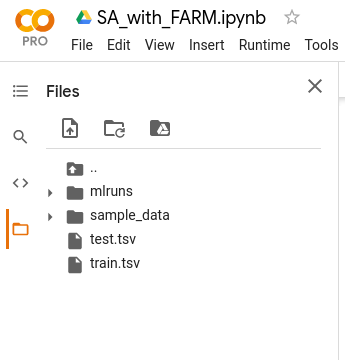

In [5]:
# In order to prepare the data for the model, we need a set of
# functions to transform data files into PyTorch Datasets.
# We group these together in Processor objects.
# We will need a new Processor object for each new source of data.
# The abstract class can be found in farm.data_handling.processor.Processor

LABEL_LIST = ["Positive", "Negative", "Neutral"]
processor = TextClassificationProcessor(tokenizer=tokenizer,
                                        max_seq_len=128,
                                        data_dir=".",
                                        label_list=LABEL_LIST,
                                        metric="f1_macro",
                                        label_column_name="coarse_label")

In [6]:
# We need a DataSilo in order to keep our train, dev and test sets separate.
# The DataSilo will call the functions in the Processor to generate these sets.
# From the DataSilo, we can fetch a PyTorch DataLoader object which will
# be passed on to the model.
# Here is a good place to define a batch size for the model

BATCH_SIZE = 32

data_silo = DataSilo(
    processor=processor,
    batch_size=BATCH_SIZE)

06/10/2021 16:25:45 - INFO - farm.data_handler.data_silo -   
Loading data into the data silo ... 
              ______
               |o  |   !
   __          |:`_|---'-.
  |__|______.-/ _ \-----.|       
 (o)(o)------'\ _ /     ( )      
 
06/10/2021 16:25:45 - INFO - farm.data_handler.data_silo -   LOADING TRAIN DATA
06/10/2021 16:25:45 - INFO - farm.data_handler.data_silo -   ==================
06/10/2021 16:25:45 - INFO - farm.data_handler.data_silo -   Loading train set from: train.tsv 
06/10/2021 16:25:45 - INFO - farm.data_handler.data_silo -   Got ya 2 parallel workers to convert 2156 dictionaries to pytorch datasets (chunksize = 216)...
06/10/2021 16:25:45 - INFO - farm.data_handler.data_silo -    0    0 
06/10/2021 16:25:45 - INFO - farm.data_handler.data_silo -   /w\  /w\
06/10/2021 16:25:45 - INFO - farm.data_handler.data_silo -   /'\  /'\
06/10/2021 16:25:45 - INFO - farm.data_handler.data_silo -     
Preprocessing Dataset train.tsv:   0%|          | 0/2156 [00:00<?, ? Di

### Modeling

In FARM, we make a strong distinction between the language model and prediction head so that you can mix and match different building blocks for your needs.

For example, in the transfer learning paradigm, you might have the one language model that you will be using for both document classification and NER. Or perhaps you have a pretrained language model which you would like to adapt to your domain, then use it for a downstream task such as question answering. 

All this is possible within FARM and requires only the replacement of a few modular components, as we shall see below.

Let's first have a look at how we might set up a model.

In [7]:
# The language model is the foundation on which modern NLP systems are built.
# They encapsulate a general understanding of sentence semantics
# and are not specific to any one task.

# Here we are using Google's BERT model as implemented by HuggingFace. 
# The model being loaded is a German model that we trained. 
# You can also change the MODEL_NAME_OR_PATH to point to a BERT model that you
# have saved or download one connected to the HuggingFace repository.
# See farm.modeling.language_model.PRETRAINED_MODEL_ARCHIVE_MAP for a list of
# available models

MODEL_NAME_OR_PATH = "bert-base-cased"

language_model = LanguageModel.load(MODEL_NAME_OR_PATH)

06/10/2021 16:26:34 - INFO - farm.modeling.language_model -   
06/10/2021 16:26:34 - INFO - farm.modeling.language_model -   LOADING MODEL
06/10/2021 16:26:34 - INFO - farm.modeling.language_model -   =============
06/10/2021 16:26:34 - INFO - farm.modeling.language_model -   Could not find bert-base-cased locally.
06/10/2021 16:26:34 - INFO - farm.modeling.language_model -   Looking on Transformers Model Hub (in local cache and online)...
06/10/2021 16:26:35 - INFO - filelock -   Lock 140425650214416 acquired on /root/.cache/huggingface/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda.lock


06/10/2021 16:26:43 - INFO - filelock -   Lock 140425650214416 released on /root/.cache/huggingface/transformers/092cc582560fc3833e556b3f833695c26343cb54b7e88cd02d40821462a74999.1f48cab6c959fc6c360d22bea39d06959e90f5b002e77e836d2da45464875cda.lock


06/10/2021 16:26:45 - INFO - farm.modeling.language_model -   Loaded bert-base-cased


In [8]:
# A prediction head is a model that processes the output of the language model
# for a specific task.
# Prediction heads will look different depending on whether you're doing text classification
# Named Entity Recognition (NER), question answering or some other task.
# They should generate logits over the available prediction classes and contain methods
# to convert these logits to losses or predictions 

# Here we use TextClassificationHead which receives a single fixed length sentence vector
# and processes it using a feed forward neural network. layer_dims is a list of dimensions:
# [input_dims, hidden_1_dims, hidden_2_dims ..., output_dims]

# Here by default we have a single layer network.
# It takes in a vector of length 768 (the default size of BERT's output).
# It outputs a vector of length 2 (the number of classes in the GermEval18 (coarse) dataset)

prediction_head = TextClassificationHead(num_labels=len(LABEL_LIST), class_weights=data_silo.calculate_class_weights(task_name="text_classification"))

06/10/2021 16:26:50 - INFO - farm.modeling.prediction_head -   Prediction head initialized with size [768, 3]
06/10/2021 16:26:50 - INFO - farm.modeling.prediction_head -   Using class weights for task 'text_classification': [3.3371893e-01 5.7700000e+02 5.7700000e+02]


In [9]:
# The language model and prediction head are coupled together in the Adaptive Model.
# This class takes care of model saving and loading and also coordinates
# cases where there is more than one prediction head.

# EMBEDS_DROPOUT_PROB is the probability that an element of the output vector from the
# language model will be set to zero.
EMBEDS_DROPOUT_PROB = 0.1

model = AdaptiveModel(
    language_model=language_model,
    prediction_heads=[prediction_head],
    embeds_dropout_prob=EMBEDS_DROPOUT_PROB,
    lm_output_types=["per_sequence"],
    device=device)

### Training

In [15]:
# Here we initialize a Bert Adam optimizer that has a linear warmup and warmdown
# Here you can set learning rate, the warmup proportion and number of epochs to train for

LEARNING_RATE = 2e-5
N_EPOCHS = 3

model, optimizer, lr_schedule = initialize_optimizer(
    model=model,
    device=device,
    learning_rate=LEARNING_RATE,
    n_batches=len(data_silo.loaders["train"]),
    n_epochs=N_EPOCHS)

06/10/2021 16:29:52 - INFO - farm.modeling.optimization -   Loading optimizer `TransformersAdamW`: '{'correct_bias': False, 'weight_decay': 0.01, 'lr': 2e-05}'
06/10/2021 16:29:52 - INFO - farm.modeling.optimization -   Using scheduler 'get_linear_schedule_with_warmup'
06/10/2021 16:29:52 - INFO - farm.modeling.optimization -   Loading schedule `get_linear_schedule_with_warmup`: '{'num_warmup_steps': 16.2, 'num_training_steps': 162}'


In [16]:
# Training loop handled by this
# It will also trigger evaluation during training using the dev data
# and after training using the test data.

# Set N_GPU to a positive value if CUDA is available
N_GPU = 1

trainer = Trainer(
    model=model,
    optimizer=optimizer,
    data_silo=data_silo,
    epochs=N_EPOCHS,
    n_gpu=N_GPU,
    lr_schedule=lr_schedule,
    device=device, 
)

In [17]:
!nvidia-smi

Thu Jun 10 16:29:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    34W / 250W |   6101MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
model = trainer.train()

06/10/2021 16:29:58 - INFO - farm.train -   
 

          &&& &&  & &&             _____                   _             
      && &\/&\|& ()|/ @, &&       / ____|                 (_)            
      &\/(/&/&||/& /_/)_&/_&     | |  __ _ __ _____      ___ _ __   __ _ 
   &() &\/&|()|/&\/ '%" & ()     | | |_ | '__/ _ \ \ /\ / / | '_ \ / _` |
  &_\_&&_\ |& |&&/&__%_/_& &&    | |__| | | | (_) \ V  V /| | | | | (_| |
&&   && & &| &| /& & % ()& /&&    \_____|_|  \___/ \_/\_/ |_|_| |_|\__, |
 ()&_---()&\&\|&&-&&--%---()~                                       __/ |
     &&     \|||                                                   |___/
             |||
             |||
             |||
       , -=-~  .-^- _
              `

Evaluating: 100%|██████████| 14/14 [00:01<00:00,  8.49it/s]
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_d

In [14]:
# Test your model on a sample (Inference)
from farm.infer import Inferencer
from pprint import PrettyPrinter

infer_model = Inferencer(processor=processor, model=model, task_type="text_classification", gpu=True)

basic_texts = [
    {"text": "Martin is happy"},
    {"text": "Martin is stupid"},
]
result = infer_model.inference_from_dicts(dicts=basic_texts)
PrettyPrinter().pprint(result)


06/10/2021 16:28:41 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
06/10/2021 16:28:41 - INFO - farm.utils -   Using device: CUDA 
06/10/2021 16:28:41 - INFO - farm.utils -   Number of GPUs: 1
06/10/2021 16:28:41 - INFO - farm.utils -   Distributed Training: False
06/10/2021 16:28:41 - INFO - farm.utils -   Automatic Mixed Precision: None
06/10/2021 16:28:41 - INFO - farm.infer -   Got ya 2 parallel workers to do inference ...
06/10/2021 16:28:41 - INFO - farm.infer -    0    0 
06/10/2021 16:28:41 - INFO - farm.infer -   /w\  /w\
06/10/2021 16:28:41 - INFO - farm.infer -   /'\  / \
06/10/2021 16:28:41 - INFO - farm.infer -     
06/10/2021 16:28:41 - INFO - farm.data_handler.processor -   *** Show 1 random examples ***
06/10/2021 16:28:41 - INFO - farm.data_handler.processor -   

      .--.        _____                       _      
    .'_\/_'.     / ____|                     | |     
    '. /\ .'    | (___   __ _ _ 

[{'predictions': [{'context': 'Martin is happy',
                   'end': None,
                   'label': 'Positive',
                   'probability': 0.999185,
                   'start': None},
                  {'context': 'Martin is stupid',
                   'end': None,
                   'label': 'Positive',
                   'probability': 0.99916005,
                   'start': None}],
  'task': 'text_classification'}]
